In [21]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [22]:
sys.path.append('../scripts')  # Add the scripts directory to the path
from load_data import load_data
from aggregiate_metrics import aggregate_user_metrics
from normalize_and_cluster import normalize_metrics, run_kmeans


In [23]:
df = aggregate_user_metrics()

Connected to the database


c:\Users\Kalea\Desktop\week-2\notebooks\../scripts\load_data.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(query, conn)


Data loaded successfully
Database connection closed


In [43]:
df.head()

,msisdn,session_frequency,total_session_duration,total_session_traffic
0,3.366211e+10,0.001984,0.000098,0.001341
1,3.361542e+10,0.003968,0.000735,0.001817
2,4.511474e+10,1.000000,1.000000,1.000000
3,3.376314e+10,0.007937,0.004131,0.004337
4,3.365845e+10,0.005952,0.002100,0.003665


In [25]:
# Step 2: Handle missing data (if any)
if df.isnull().sum().sum() > 0:
    print("Missing values detected. Filling with column mean...")   
    df = df.fillna(df.mean())  # Fill missing values with column mean


Missing values detected. Filling with column mean...


In [44]:
# Step 3: Normalize the engagement metrics
columns_to_normalize = ['session_frequency', 'total_session_duration', 'total_session_traffic']
df = normalize_metrics(df)

In [45]:
df.head()

,msisdn,session_frequency,total_session_duration,total_session_traffic
0,3.366211e+10,0.001984,0.000098,0.001341
1,3.361542e+10,0.003968,0.000735,0.001817
2,4.511474e+10,1.000000,1.000000,1.000000
3,3.376314e+10,0.007937,0.004131,0.004337
4,3.365845e+10,0.005952,0.002100,0.003665


In [46]:
# Step 4: K-means Clustering (using k=3 for now)
df = run_kmeans(df, n_clusters=3)

c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [47]:
# Step 5: Descriptive statistics for each cluster
cluster_stats = df.groupby('engagement_cluster')[['session_frequency', 'total_session_duration', 'total_session_traffic']].agg(['min', 'max', 'mean', 'sum'])
print("\nCluster Descriptive Statistics:\n", cluster_stats)
# top_clusters_percentage
top_clusters_percentage = df.groupby('engagement_cluster').size() / len(df) * 100
print("\nTop Clusters Percentage:\n", top_clusters_percentage)



Cluster Descriptive Statistics:
                    session_frequency                                  \
                                 min       max      mean         sum   
engagement_cluster                                                     
0                           0.000000  0.007937  0.002389  232.128968   
1                           0.001984  0.035714  0.006450   62.525794   
2                           1.000000  1.000000  1.000000    1.000000   

                   total_session_duration                                  \
                                      min       max      mean         sum   
engagement_cluster                                                          
0                                0.000000  0.006615  0.001462  142.005671   
1                                0.000821  0.256030  0.006506   63.071981   
2                                1.000000  1.000000  1.000000    1.000000   

                   total_session_traffic                              

In [41]:
cluster_stats.head()

session_frequency                                  \
                                 min       max      mean         sum   
engagement_cluster                                                     
0                           0.000000  0.007937  0.002389  232.128968   
1                           0.001984  0.035714  0.006450   62.525794   
2                           1.000000  1.000000  1.000000    1.000000   

                   total_session_duration                                  \
                                      min       max      mean         sum   
engagement_cluster                                                          
0                                0.000000  0.006615  0.001462  142.005671   
1                                0.000821  0.256030  0.006506   63.071981   
2                                1.000000  1.000000  1.000000    1.000000   

                   total_session_traffic                                  
                                     min       max      mean         sum  
engagement_cluster                                                        
0                               0.000000  0.004529  0.001062  103.148798  
1                               0.000045  0.016590  0.003007   29.152621  
2                               1.000000  1.000000  1.000000    1.000000

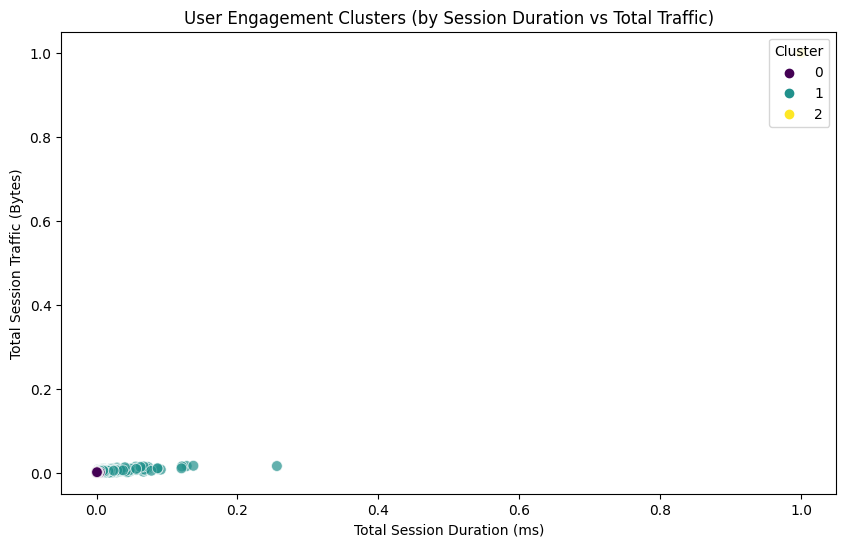

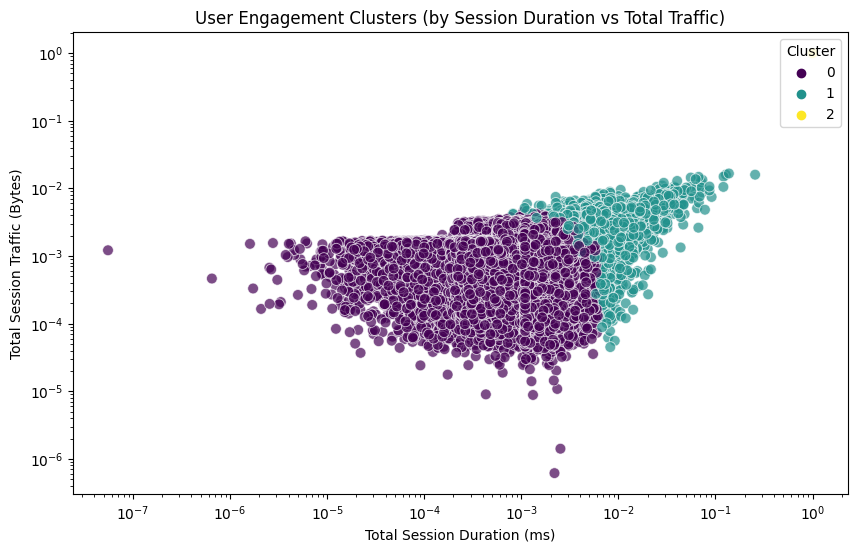

In [53]:

# Step 6: Plot the engagement clusters using a scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_session_duration', y='total_session_traffic', hue='engagement_cluster', data=df, palette='viridis', s=60, alpha=0.7)
plt.title('User Engagement Clusters (by Session Duration vs Total Traffic)')
plt.xlabel('Total Session Duration (ms)')
plt.ylabel('Total Session Traffic (Bytes)')
plt.legend(title='Cluster', loc='upper right')
plt.show()
#log scale
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_session_duration', y='total_session_traffic', hue='engagement_cluster', data=df, palette='viridis', s=60, alpha=0.7)
plt.title('User Engagement Clusters (by Session Duration vs Total Traffic)')
plt.xlabel('Total Session Duration (ms)')
plt.ylabel('Total Session Traffic (Bytes)')
plt.legend(title='Cluster', loc='upper right')
plt.xscale('log')
plt.yscale('log')
plt.show()


c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

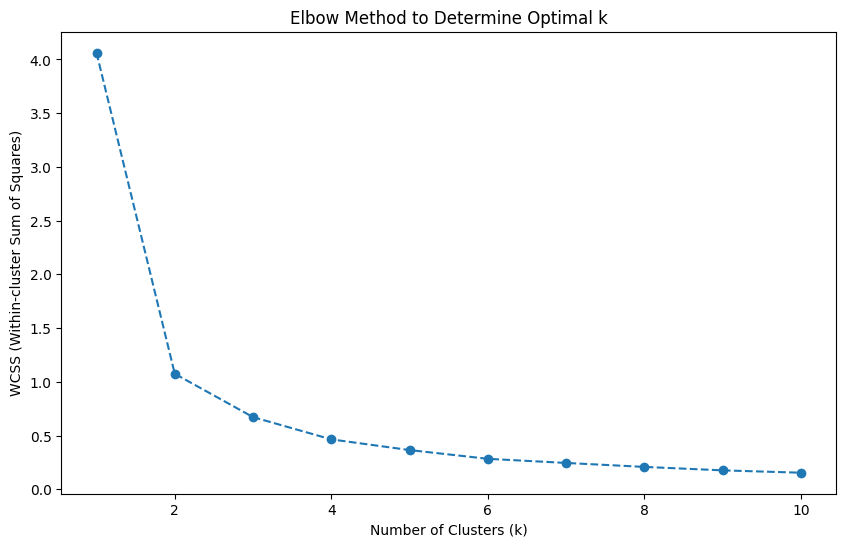

In [16]:
# Step 7: Determine optimal k using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df[columns_to_normalize])
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

In [17]:
query = """
SELECT 
    "MSISDN/Number" as msisdn, 
    SUM("Youtube DL (Bytes)") + SUM("Youtube UL (Bytes)") AS youtube_traffic, 
    SUM("Gaming DL (Bytes)") + SUM("Gaming UL (Bytes)") AS gaming_traffic, 
    SUM("Social Media DL (Bytes)") + SUM("Social Media UL (Bytes)") AS social_media_traffic 
FROM xdr_data 
GROUP BY "MSISDN/Number";
"""

In [18]:
df_apps = load_data(query)

Connected to the database


c:\Users\Kalea\Desktop\week-2\notebooks\../scripts\load_data.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(query, conn)


Data loaded successfully
Database connection closed


In [19]:
# View the top 10 users for each application
top_users_youtube = df_apps[['msisdn', 'youtube_traffic']].sort_values(by='youtube_traffic', ascending=False).head(10)
top_users_gaming = df_apps[['msisdn', 'gaming_traffic']].sort_values(by='gaming_traffic', ascending=False).head(10)
top_users_social = df_apps[['msisdn', 'social_media_traffic']].sort_values(by='social_media_traffic', ascending=False).head(10)

print("\nTop 10 Users for YouTube Traffic:\n", top_users_youtube)
print("\nTop 10 Users for Gaming Traffic:\n", top_users_gaming)
print("\nTop 10 Users for Social Media Traffic:\n", top_users_social)


Top 10 Users for YouTube Traffic:
               msisdn  youtube_traffic
3                NaN     2.434073e+10
53027   3.362578e+10     4.529588e+08
19150   3.376054e+10     3.962892e+08
31575   3.361489e+10     3.943702e+08
64661   3.362632e+10     3.744830e+08
32116   3.367588e+10     3.174106e+08
100583  3.366716e+10     3.152313e+08
6199    3.362708e+10     3.087908e+08
40456   3.376041e+10     3.031691e+08
4852    3.369879e+10     3.026620e+08

Top 10 Users for Gaming Traffic:
               msisdn  gaming_traffic
3                NaN    4.614780e+11
31575   3.361489e+10    7.749432e+09
19150   3.376054e+10    7.461045e+09
53027   3.362578e+10    7.326673e+09
32116   3.367588e+10    6.970568e+09
64661   3.362632e+10    6.887572e+09
32999   3.365973e+10    6.725559e+09
97294   3.366646e+10    6.646303e+09
40456   3.376041e+10    6.268620e+09
102736  3.366471e+10    6.103856e+09

Top 10 Users for Social Media Traffic:
               msisdn  social_media_traffic
3                NaN

{'YouTube': 4.978725151559884, 'Gaming': 94.6192891892849, 'Social Media': 0.40198565915520024}


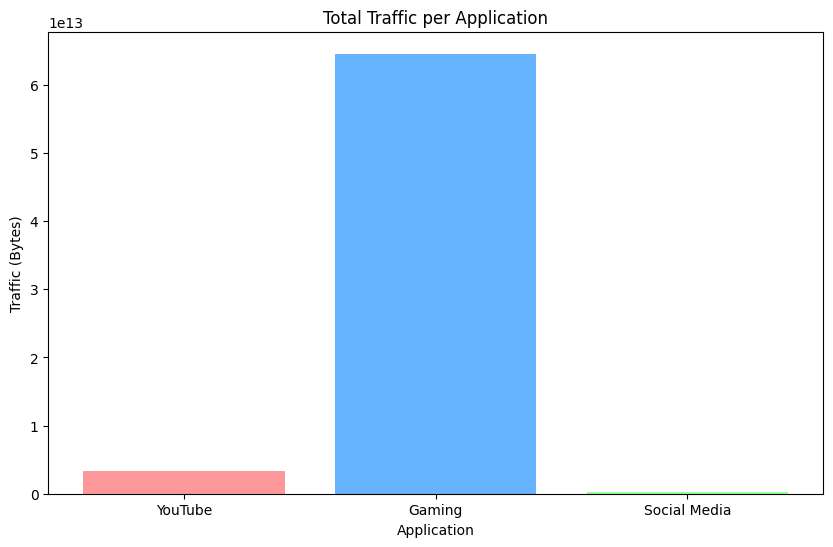

In [39]:
# Plot the top 3 most used applications
total_traffic_per_app = {
    'YouTube': df_apps['youtube_traffic'].sum(),
    'Gaming': df_apps['gaming_traffic'].sum(),
    'Social Media': df_apps['social_media_traffic'].sum()
}
total_traffic_per_app_percentage = {
    'YouTube': df_apps['youtube_traffic'].sum() / df_apps['total_traffic'].sum() * 100,
    'Gaming': df_apps['gaming_traffic'].sum() / df_apps['total_traffic'].sum() * 100,
    'Social Media': df_apps['social_media_traffic'].sum() / df_apps['total_traffic'].sum() * 100
}
print(total_traffic_per_app_percentage)
plt.figure(figsize=(10, 6))
plt.bar(total_traffic_per_app.keys(), total_traffic_per_app.values(), color=['#ff9999','#66b3ff','#99ff99'])
plt.title('Total Traffic per Application')
plt.xlabel('Application')
plt.ylabel('Traffic (Bytes)')
plt.show()
